In [1]:
untar("data/pbmc3k_filtered_gene_bc_matrices.tar.gz", exdir="data")

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)

# Load the PBMS dataset
pbmc.data <- Read10X(data.dir = "./data/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object witht the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [26]:
options(repr.plot.width=10, repr.plot.height=8)

In [4]:
pbmc.data[c("CD3D","TCL1A","MS4A1"), 1:30]

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

In [5]:
dense.size <- object.size(as.matrix(pbmc.data))
dense.size

709591472 bytes

In [6]:
sparse.size <- object.size(pbmc.data)
sparse.size

29905192 bytes

In [7]:
dense.size/sparse.size

23.7 bytes

## Standard pre-processing workflow

In [8]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [9]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


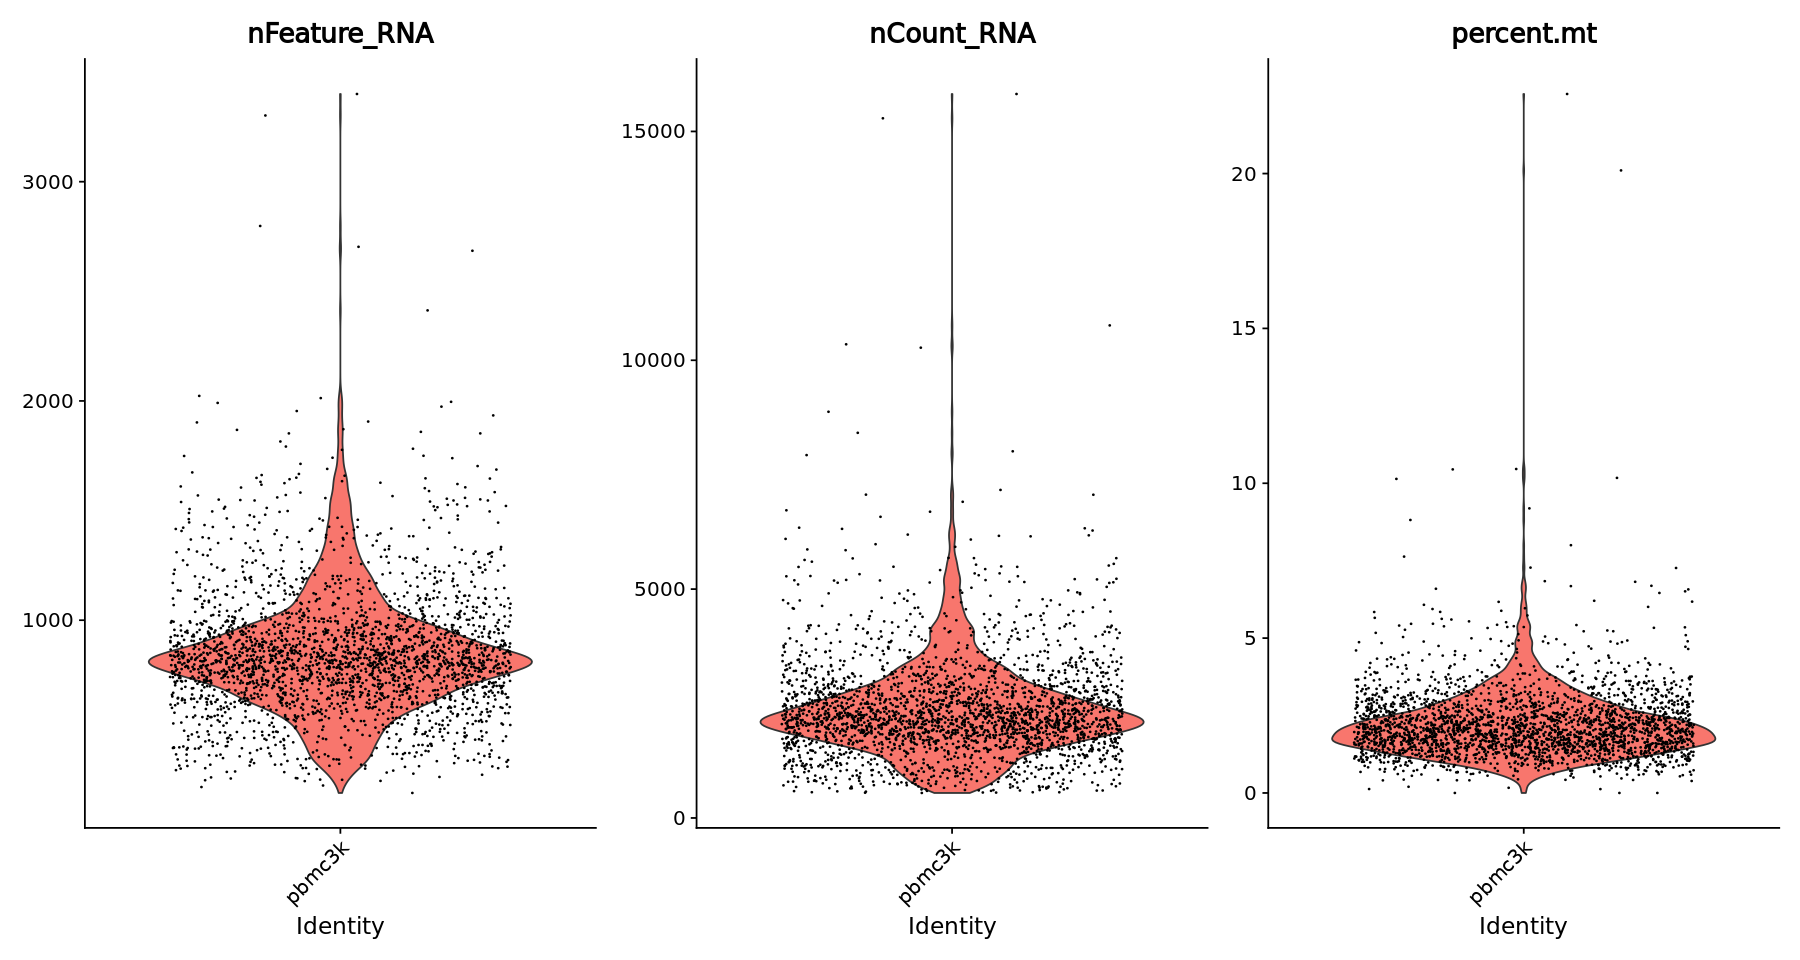

In [10]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

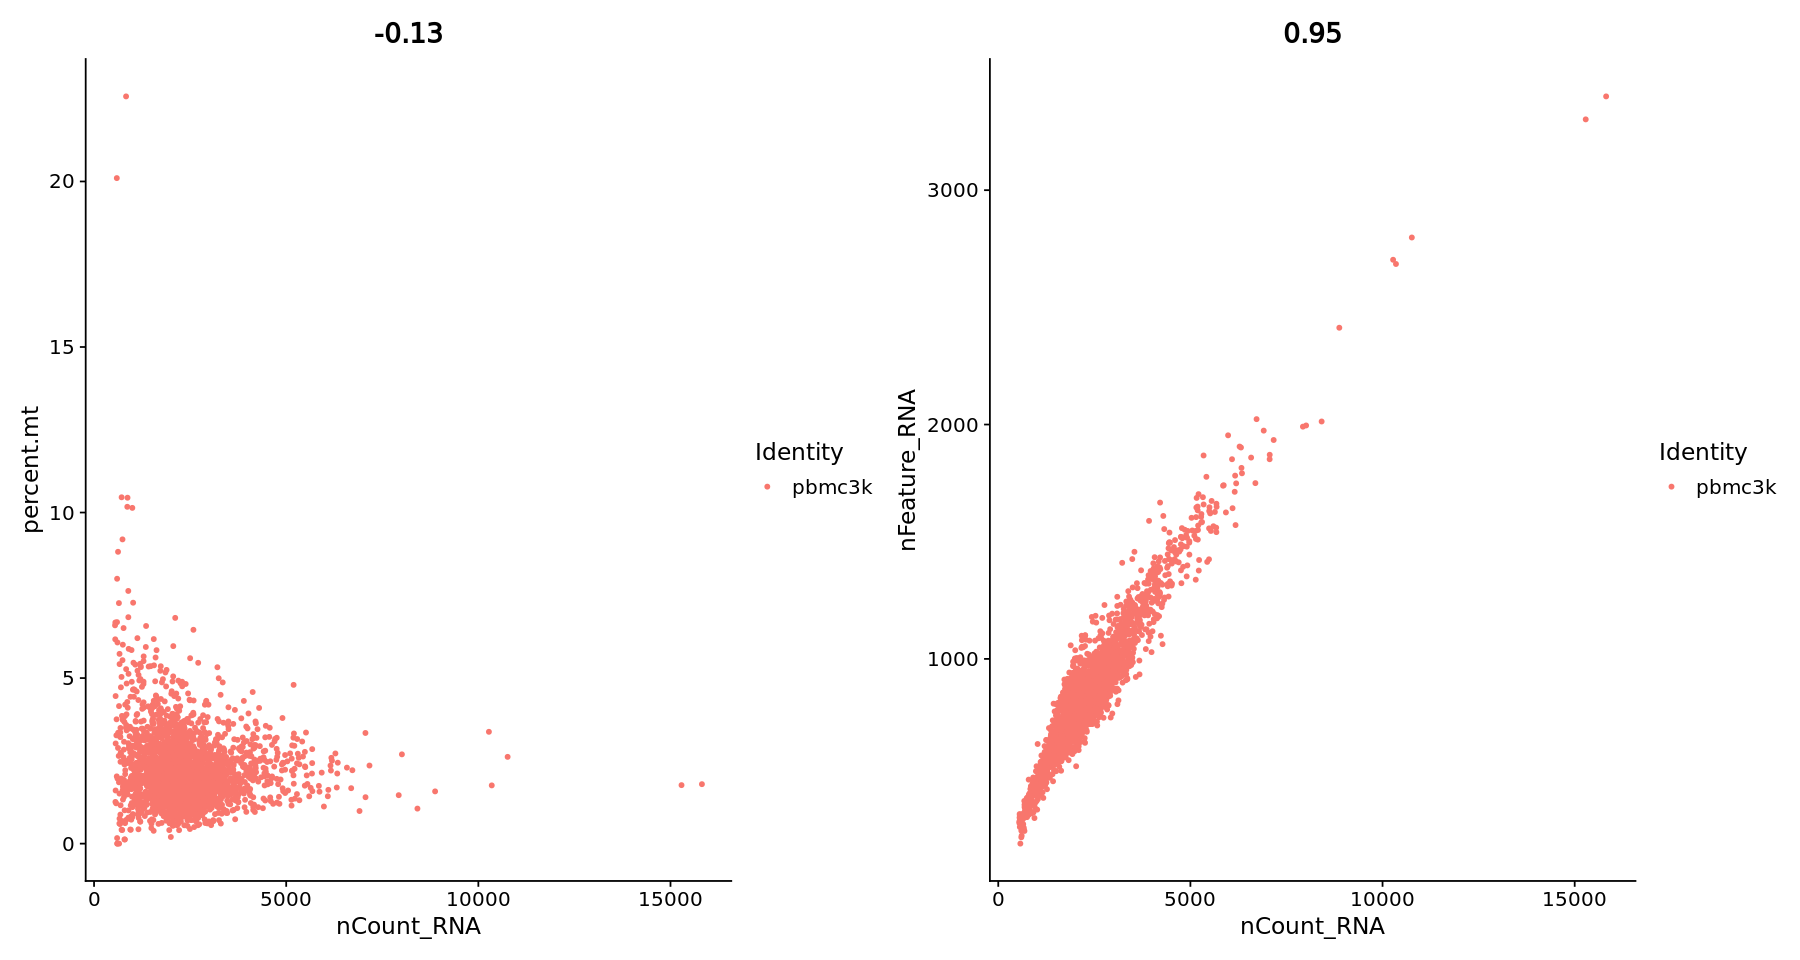

In [11]:
# FeatureScatter is typically used  to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [12]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

In [13]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
# Since the parameters are default values, this can also be achieved by
pbmc <- NormalizeData(pbmc)

# Identification of highly variable features (feature selection)

In [16]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

In [29]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, xnudge = 0, ynudge = 0, repel = TRUE)
plot1 + plot2

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
ERROR while rich displaying an object: Error in `value[[3L]]()`:
! The viewport may be too small to show this patchwork.
ℹ Please make the window larger.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2

## Scaling the Data

In [30]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## Perform Linear Dimensional Reduction

In [32]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [33]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, SDPR, PF4, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, S100A8, NKG7, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


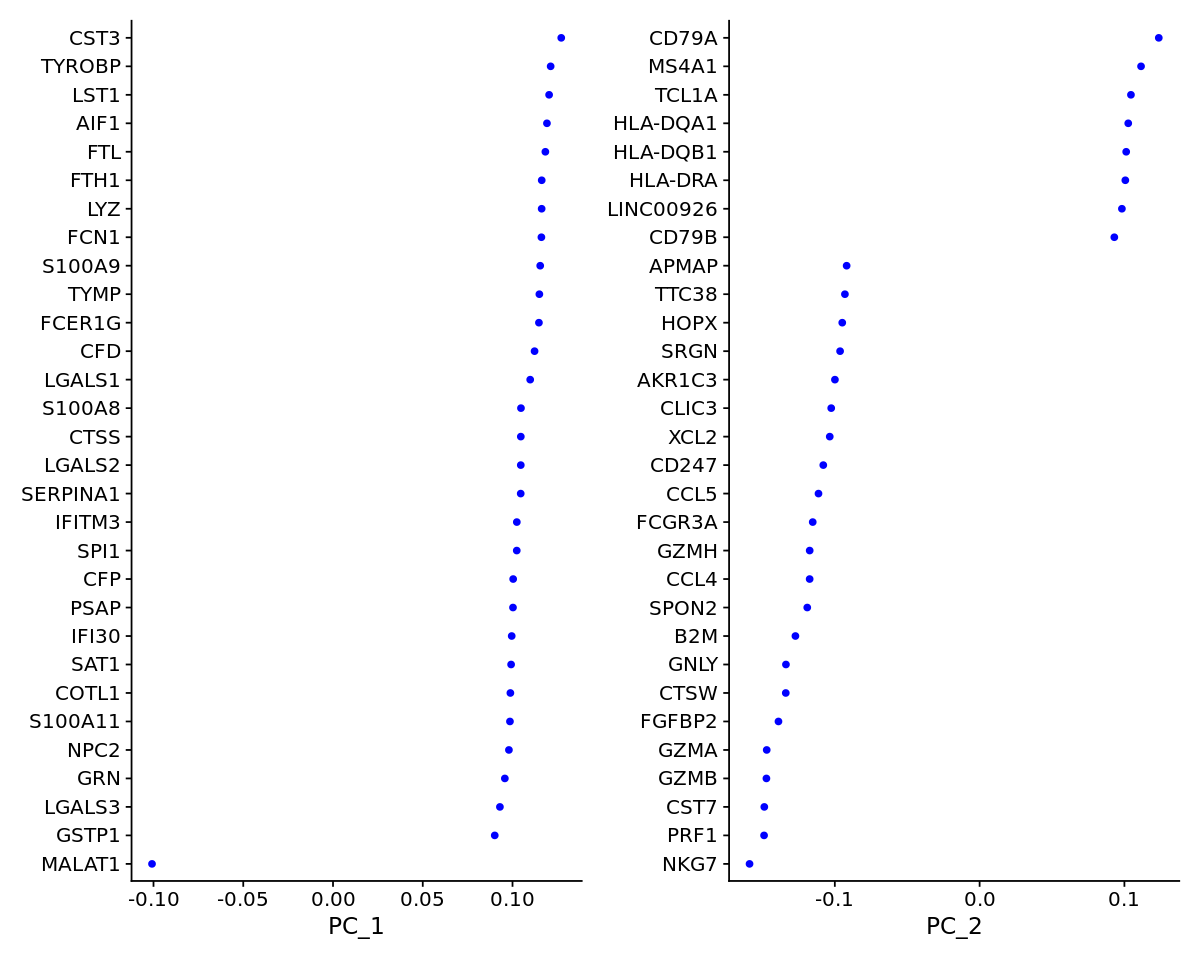

In [34]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

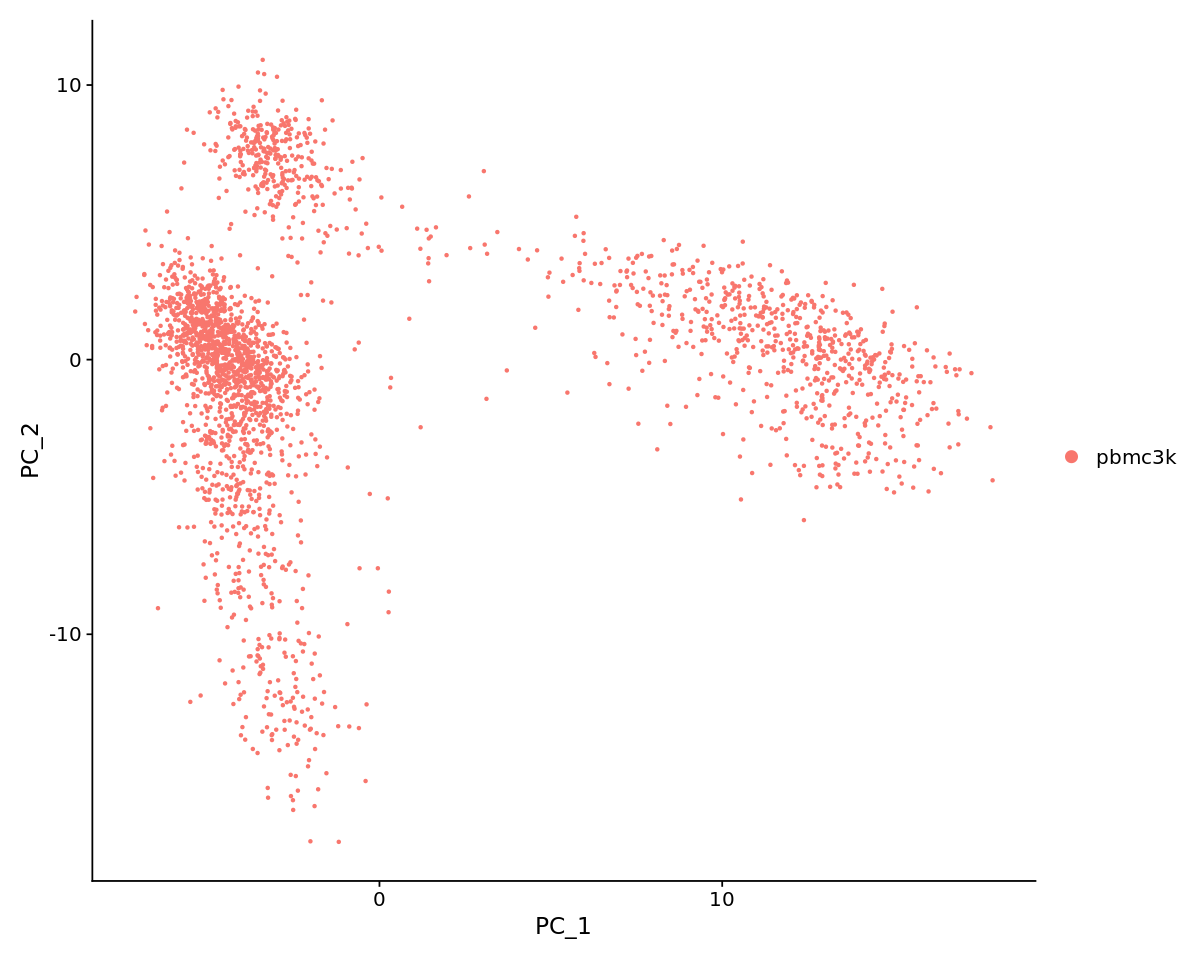

In [35]:
DimPlot(pbmc, reduction = "pca")

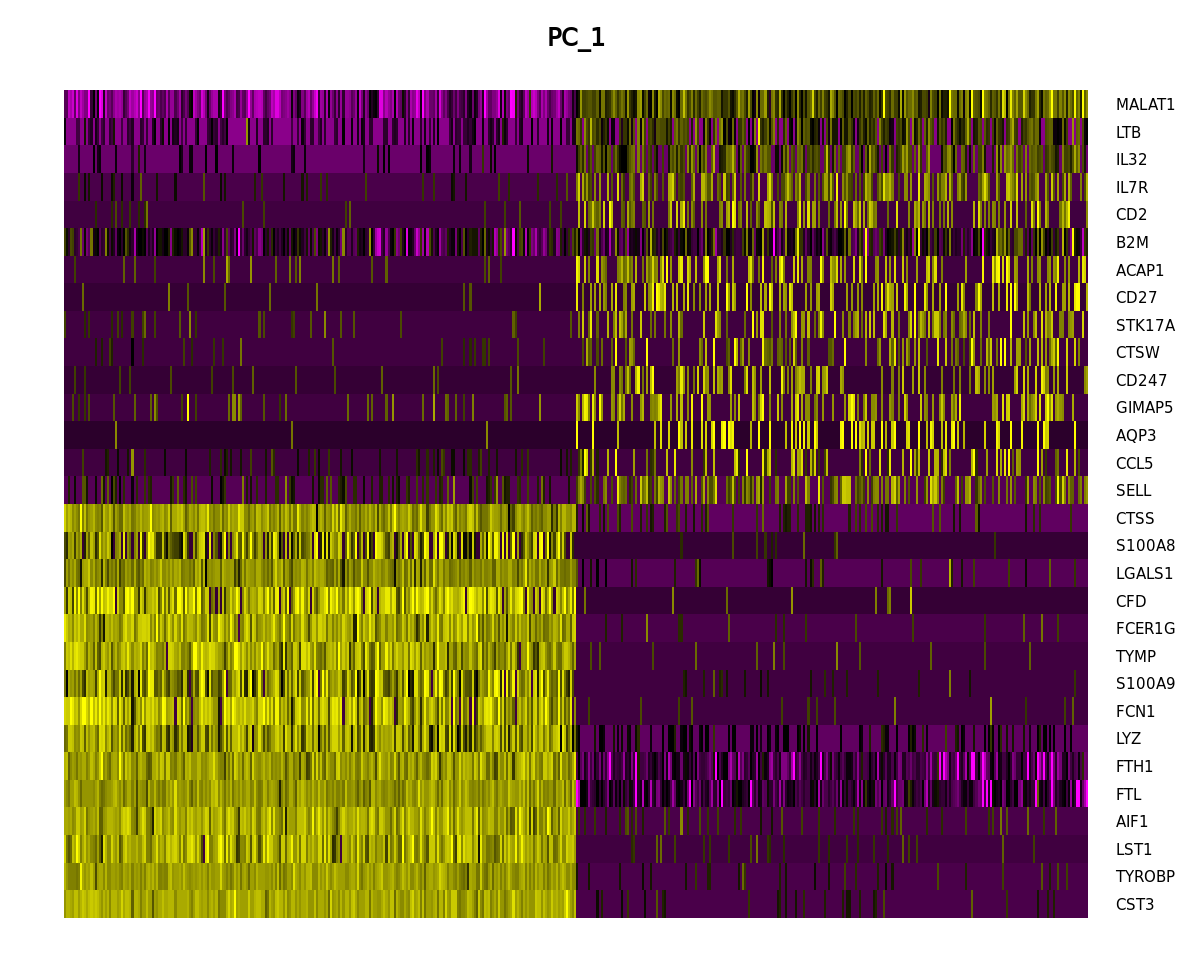

In [36]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

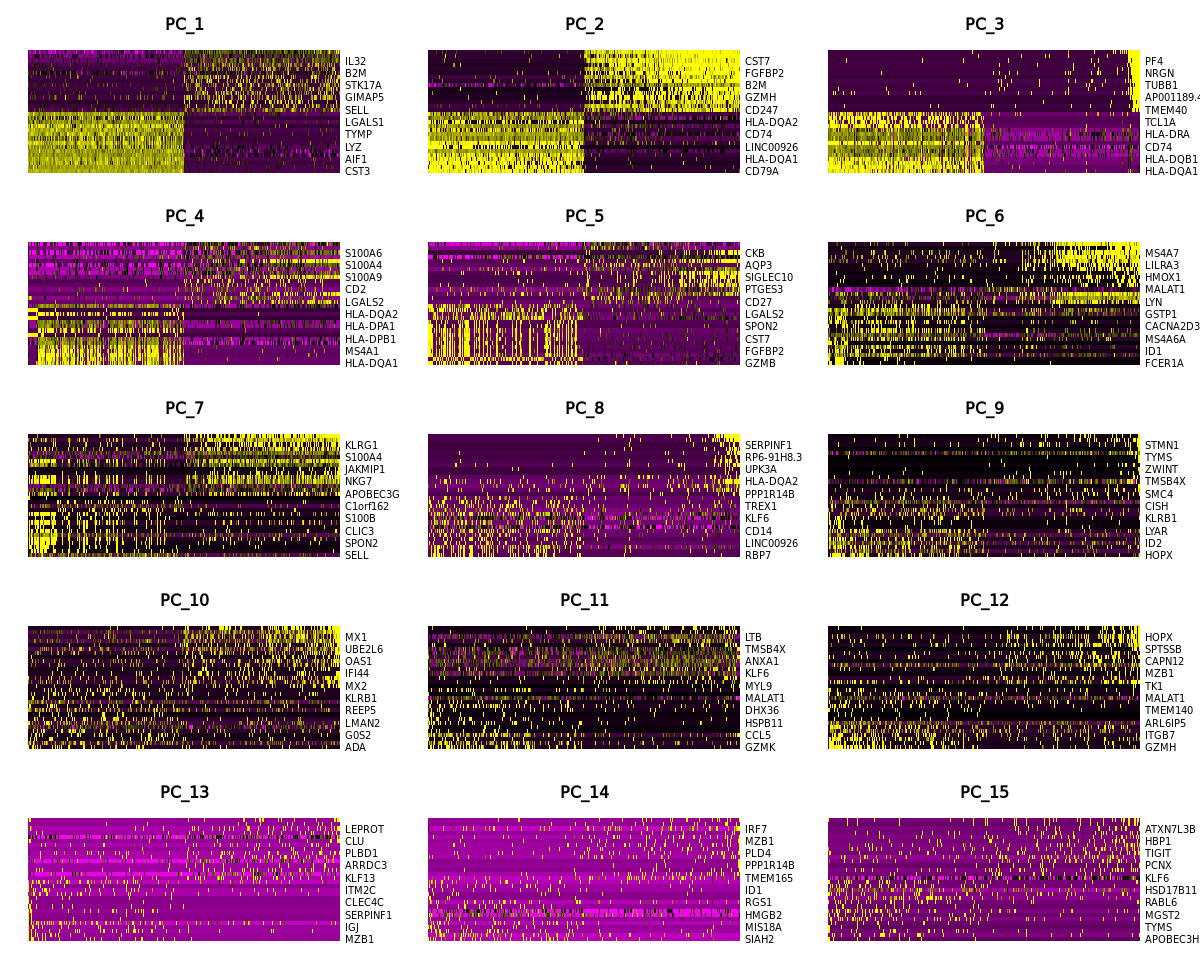

In [37]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the 'dimensionality' of the dataset

In [38]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23516 rows containing missing values (`geom_point()`).”


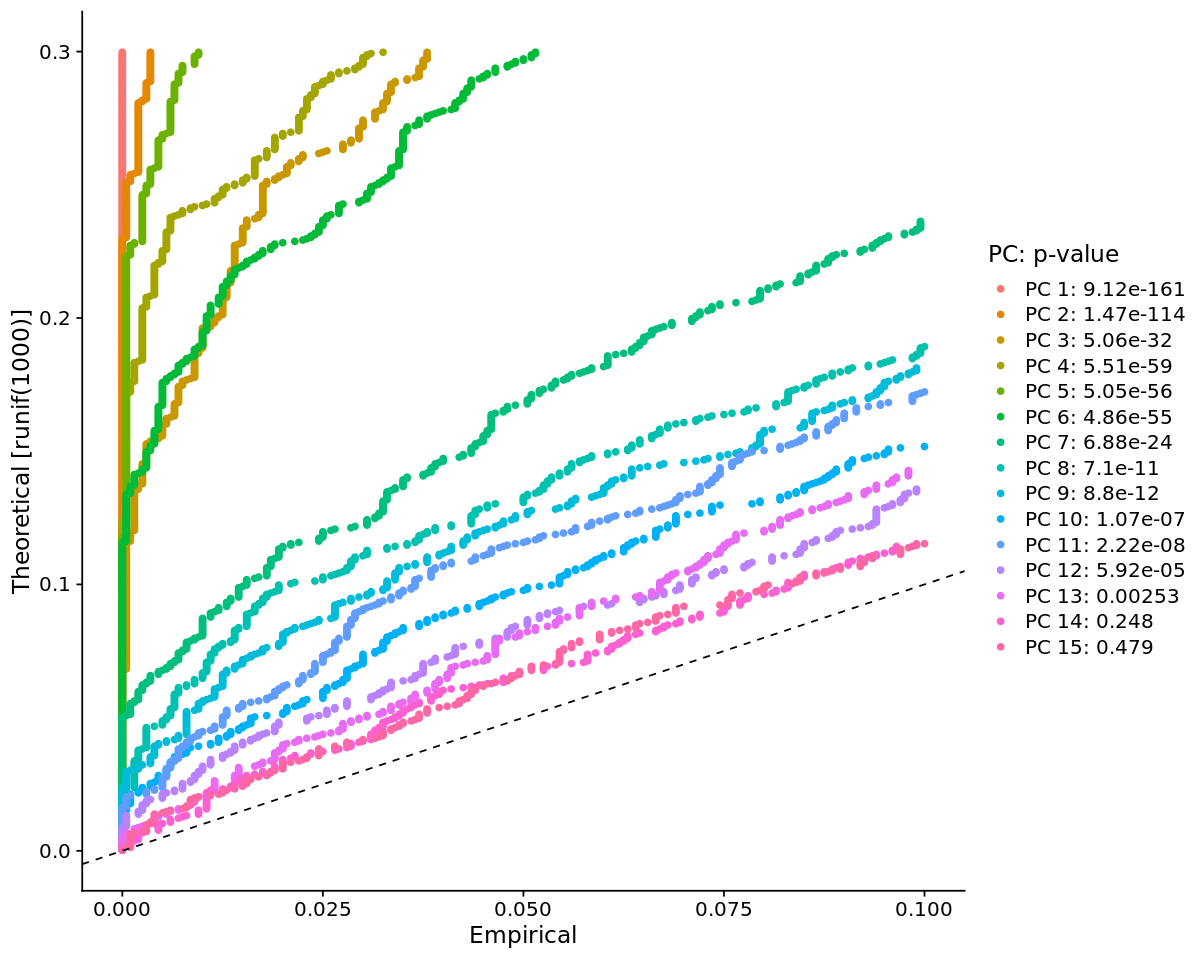

In [39]:
JackStrawPlot(pbmc, dims = 1:15)

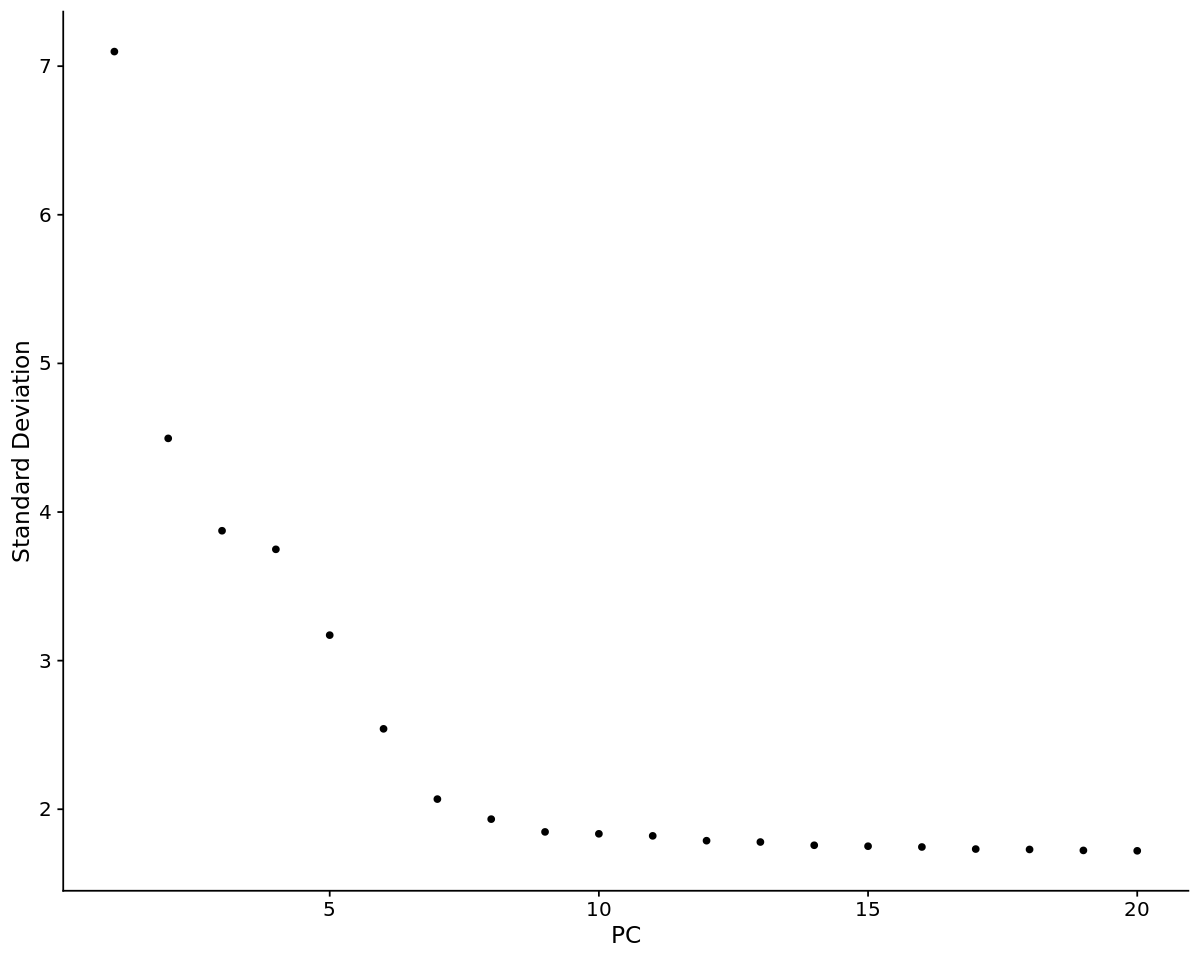

In [40]:
ElbowPlot(pbmc)

## Cluster the cells

In [41]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8722
Number of communities: 9
Elapsed time: 0 seconds


In [42]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               1                3                1                2 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)

In [44]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
02:13:24 UMAP embedding parameters a = 0.9922 b = 1.112

02:13:24 Read 2638 rows and found 10 numeric columns

02:13:24 Using Annoy for neighbor search, n_neighbors = 30

02:13:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:13:24 Writing NN index file to temp file /tmp/RtmpVrP9Eo/file1826aaea178

02:13:24 Searching Annoy index using 1 thread, search_k = 3000

02:13:24 Annoy recall = 100%

02:13:24 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

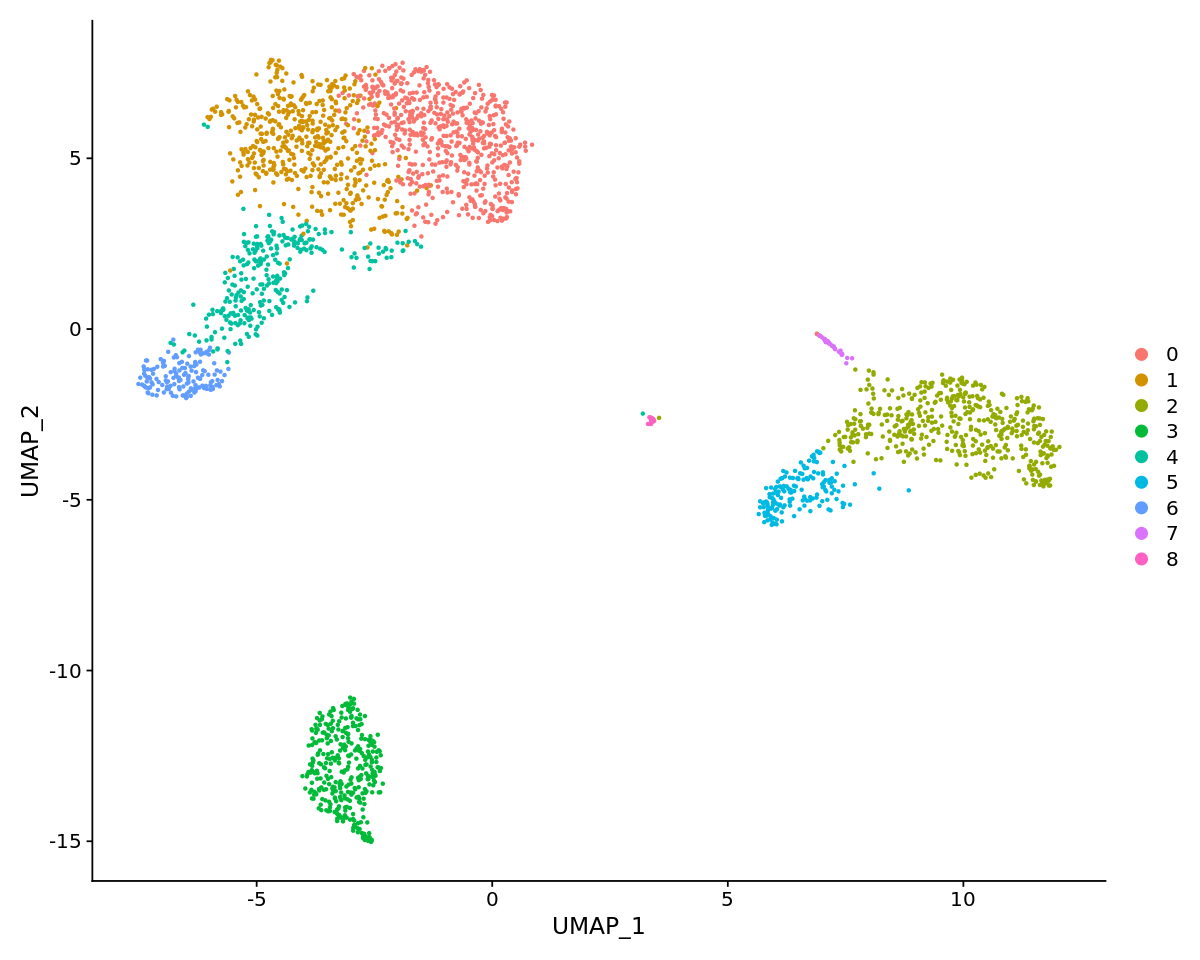

In [45]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

In [50]:
dir.create("pbmc_tutorial")

In [51]:
saveRDS(pbmc, file = "./pbmc_tutorial/pbmc_tutorial.rds")

## Finding differentially expressed features (cluster biomarkers)

In [52]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,0.000000e+00,5.570063,0.996,0.215,0.000000e+00
S100A8,0.000000e+00,5.477394,0.975,0.121,0.000000e+00
FCN1,0.000000e+00,3.394219,0.952,0.151,0.000000e+00
LGALS2,0.000000e+00,3.800484,0.908,0.059,0.000000e+00
CD14,2.856582e-294,2.815626,0.667,0.028,3.917516e-290


In [53]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,1.503232e-201,4.272769,0.975,0.038,2.061532e-197
CFD,1.113563e-190,3.421544,0.938,0.036,1.527140e-186
IFITM3,1.609194e-190,3.870255,0.975,0.049,2.206849e-186
CD68,1.649886e-185,3.012542,0.926,0.036,2.262654e-181
RP11-290F20.3,1.408433e-180,2.716446,0.840,0.017,1.931525e-176


In [54]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.953049e-92,1.390891,0.464,0.109,2.678412e-88,0,CCR7
2.476123e-35,1.163925,0.263,0.082,3.395754e-31,0,LDLRAP1
7.690348e-92,1.280391,0.977,0.638,1.054654e-87,1,LTB
7.963064e-102,1.259050,0.949,0.456,1.092055e-97,1,IL32
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,2,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,2,S100A8
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
2.236620e-200,3.102183,0.979,0.234,3.067300e-196,4,CCL5


In [55]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

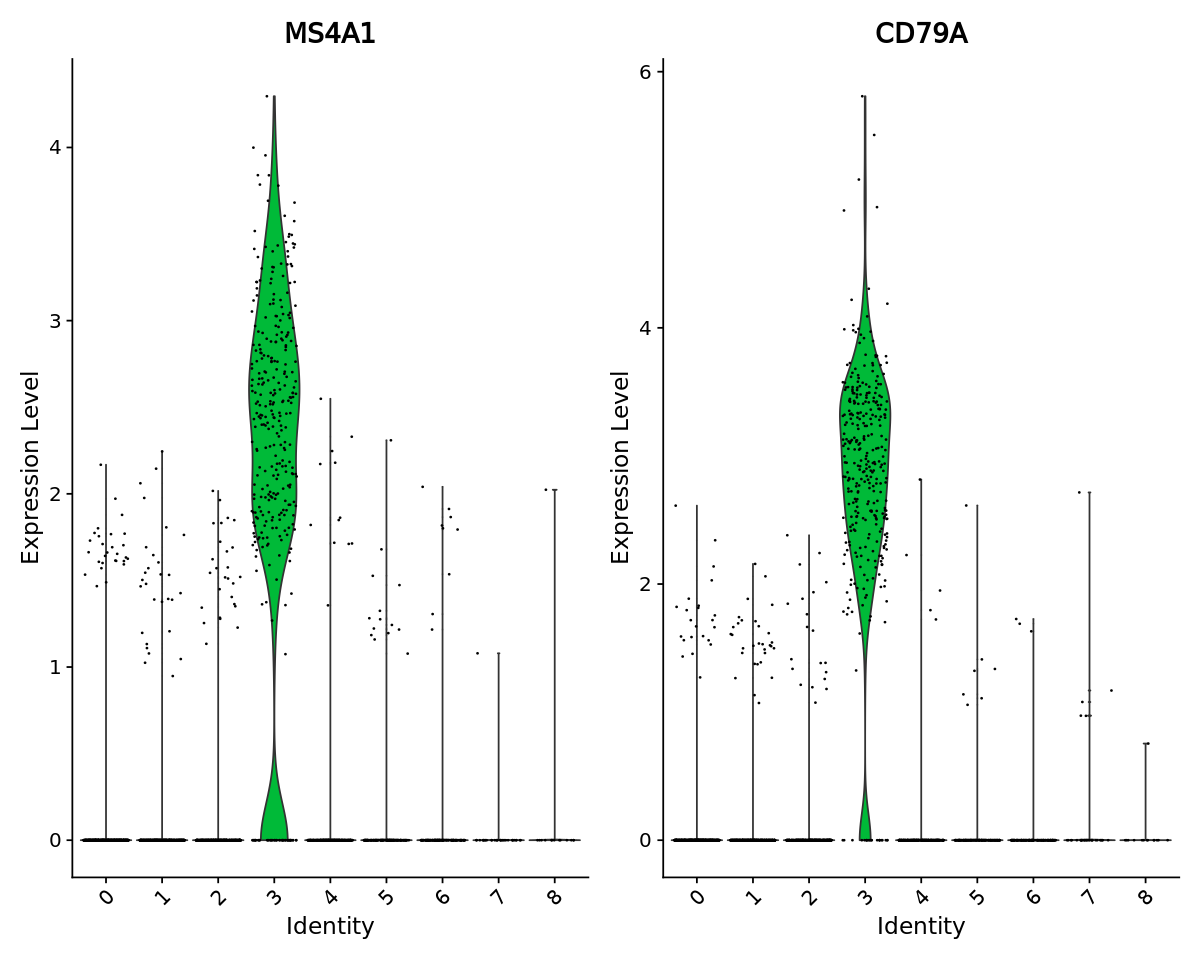

In [56]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

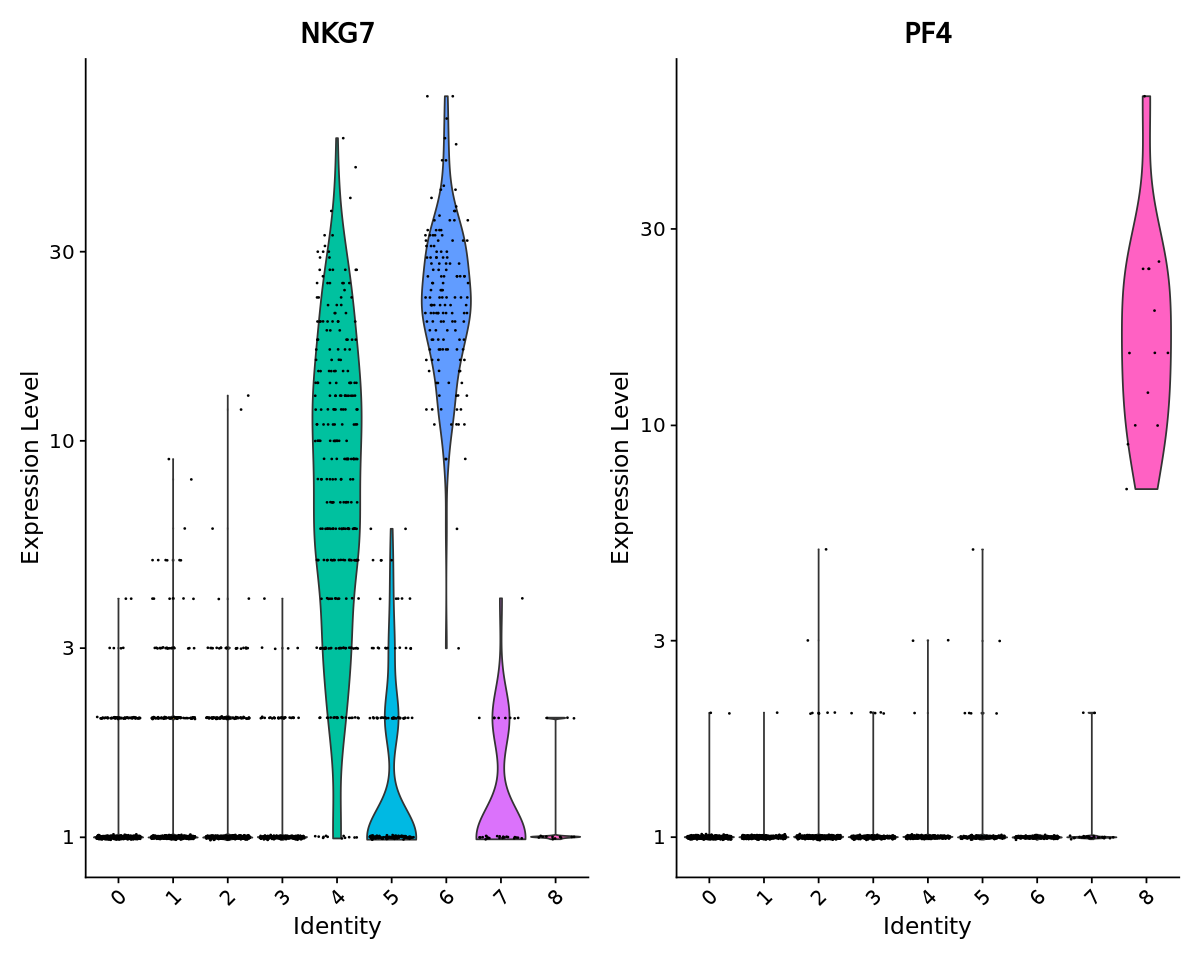

In [57]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

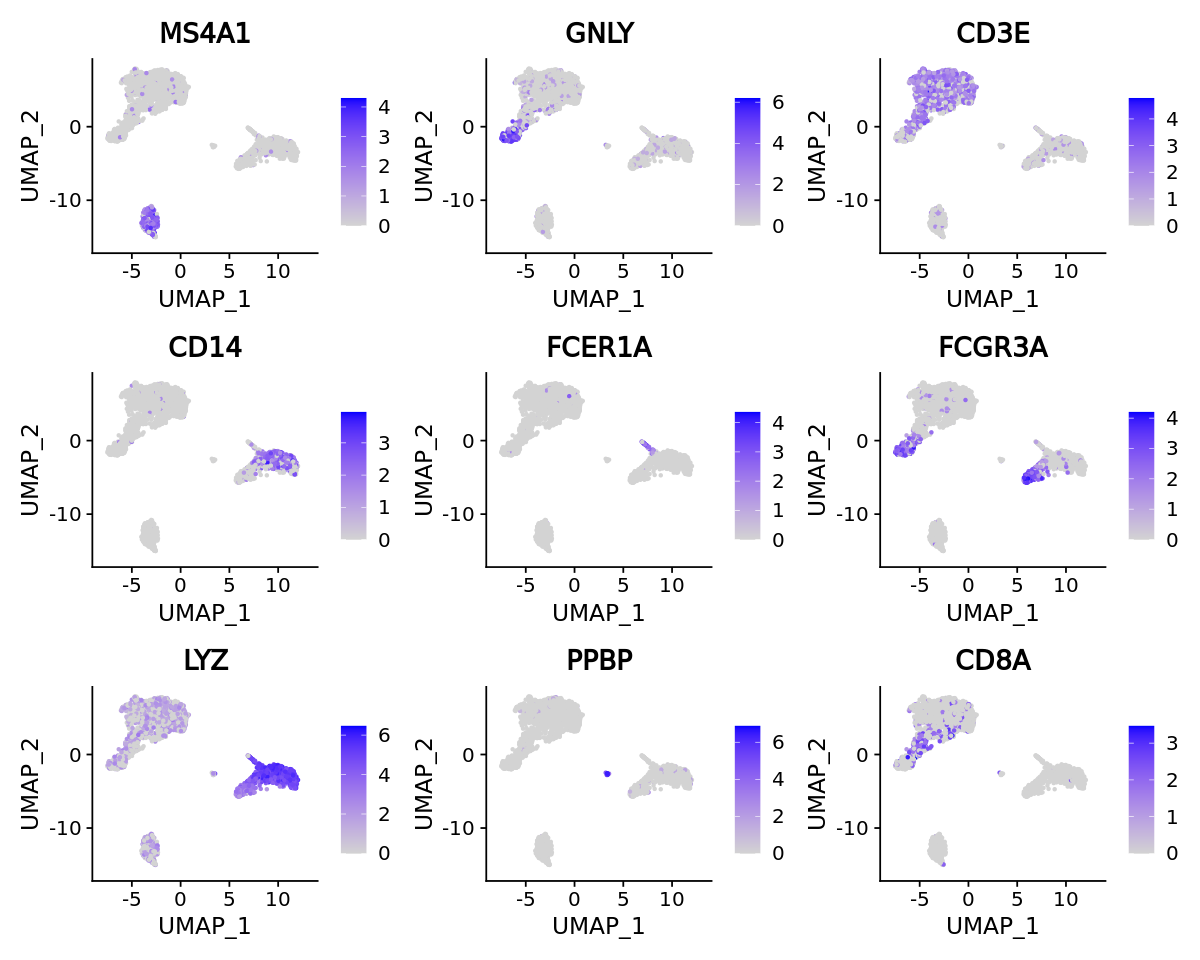

In [58]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

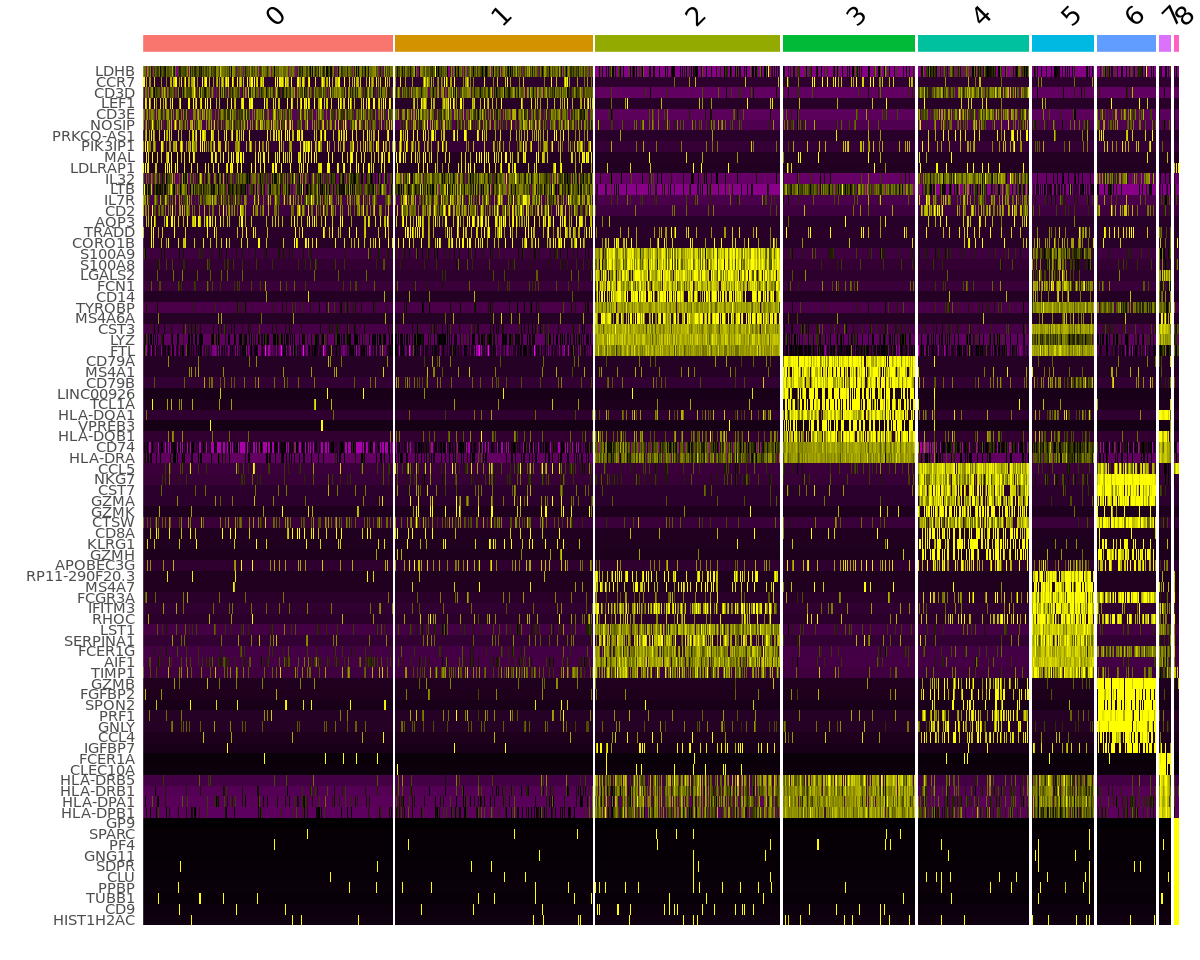

In [59]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()